# 1、读入数据

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
data = pd.read_csv('data.csv')
data #label为0表示风格为南派，label为1表示风格为北派

,melody,label
0,A40.375 B40.125 D50.25 E50.25 C50.25 D50.25 A4...,0
1,E52.0,0
2,Cp51.0 B41.0 Dp51.0,1
3,G40.75 A40.25 C50.75 B40.25 A40.5,1
4,C50.25 A40.25 G40.25 E40.25 D40.25 C40.75 A30....,0
...,...,...
10913,Fp40.5 E40.5 Fp40.25 A40.25 E40.5 D40.5 B30.25,1
10914,A40.25 Fp41.0 E40.5 Fp40.25,1
10915,C40.25 C40.25 B30.5 C40.25 C40.25 B30.5 C40.25,1
10916,D50.5 F50.5 C50.5 A40.5 G40.5 D40.5,0


# 2、数据预处理

## 2.1 Bag-of-Words 

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(token_pattern = "\\b\\w+.\\w+\\b")
bow_vectorizer.fit(data['melody'].values)
bow = bow_vectorizer.transform(data['melody'])
bow = bow.toarray()

## 2.2 TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(norm = None, token_pattern = "\\b\\w+.\\w+\\b")
tfidf_vectorizer.fit(data['melody'].values)
tf_idf = tfidf_vectorizer.transform(data['melody'].values)
tf_idf = tf_idf.toarray()

## 2.3 word2ec

In [11]:
from gensim.models.word2vec import Word2Vec
import numpy as np

data = pd.read_csv('data.csv')

#把以空格隔开的字符串转成列表,最终结果存在token_data中
token_data = []

for i in range(len(data['melody'].values)):
     token_data.append(data['melody'].values[i].split(' '))
        

#sg=0:CBOW
CBOW = Word2Vec(sg = 0, min_count = 1)
CBOW.build_vocab(token_data)
CBOW.train(token_data,
            total_examples = CBOW.corpus_count,
            epochs = CBOW.epochs)

# #sg=1:skip-gram
skipgram = Word2Vec(sg = 1, min_count = 1)
skipgram.build_vocab(token_data)
skipgram.train(token_data,
            total_examples = skipgram.corpus_count,
            epochs = skipgram.epochs)

(141585, 305965)

In [12]:
#使用求均值的方法把词向量转化为句子向量
#cbow
cbow = np.zeros((len(data), len(CBOW[token_data[0][0]])))
i = 0
for item in token_data:
    temp = np.zeros((len(CBOW[item[0]]),))
    for subitem in item:
        temp = temp + CBOW[subitem]
    cbow[i] = temp
    i += 1
    
#skip-gram
skip_gram = np.zeros((len(data), len(skipgram[token_data[0][0]])))
i = 0
for item in token_data:
    temp = np.zeros((len(skipgram[item[0]]),))
    for subitem in item:
        temp = temp + skipgram[subitem]
    skip_gram[i] = temp
    i += 1

## 2.4 关于CNN模型的特殊数据预处理

In [49]:
#使用的模型中比较特殊的是CNN，以词向量矩阵作为输入而不是直接使用句子向量
#在这里构造textCNN的等长输入
from torch.nn.utils.rnn import pad_sequence
import torch

#bow
CNN_bow_list = []
for item in token_data:
    temp = bow_vectorizer.transform(item).toarray()
    CNN_bow_list.append(temp)
CNN_bow = pad_sequence([torch.from_numpy(np.array(x)) for x in CNN_bow_list], batch_first=True).float()
CNN_bow = CNN_bow.numpy()

#tf_idf
CNN_tf_idf_list = []
for item in token_data:
    temp = tfidf_vectorizer.transform(item).toarray()
    CNN_tf_idf_list.append(temp)
CNN_tf_idf = pad_sequence([torch.from_numpy(np.array(x)) for x in CNN_tf_idf_list], batch_first=True).float()
CNN_tf_idf = CNN_tf_idf.numpy()

#cbow
CNN_CBOW_list = []
for item in token_data:
    temp = np.zeros((len(item),len(CBOW[item[0]])))
    for i in range(len(item)):
        subitem = item[i]
        temp[i] = CBOW[subitem]
    CNN_CBOW_list.append(temp)
CNN_CBOW = pad_sequence([torch.from_numpy(np.array(x)) for x in CNN_CBOW_list], batch_first=True).float()
CNN_CBOW = CNN_CBOW.numpy()

#skip_gram
CNN_skipgram_list = []
for item in token_data:
    temp = np.zeros((len(item),len(skipgram[item[0]])))
    for i in range(len(item)):
        subitem = item[i]
        temp[i] = skipgram[subitem]
    CNN_skipgram_list.append(temp)
CNN_skipgram = pad_sequence([torch.from_numpy(np.array(x)) for x in CNN_skipgram_list], batch_first=True).float()
CNN_skipgram = CNN_skipgram.numpy()

# 3、机器学习模型构建及实验

## 3.1 传统机器学习模型

### （1）决策树

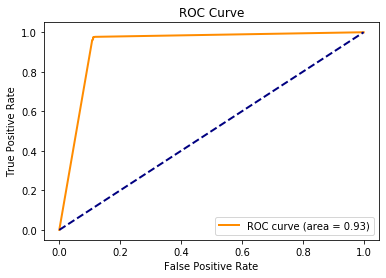

recall of bow+tree is 0.9691075138653547
f1score of bow+tree is 0.9623093761590669



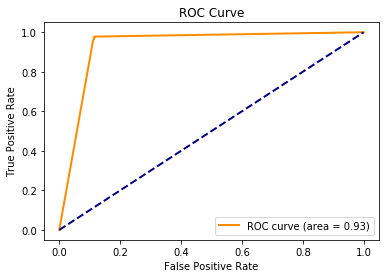

recall of tfidf+tree is 0.9700013277958538
f1score of tfidf+tree is 0.9629385097815744



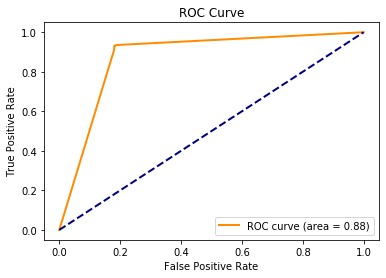

recall of cbow+tree is 0.9233205580145019
f1score of cbow+tree is 0.9221946130389391



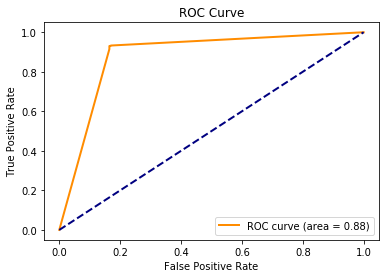

recall of skip_gram+tree is 0.928879130249368
f1score of skip_gram+tree is 0.9252226345985827



In [28]:
from sklearn.model_selection import KFold
from sklearn import tree, metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

cv = KFold(n_splits=10, shuffle=True, random_state=1)

def draw_roc(y_score,y_test):
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1]);
    roc_auc = auc(fpr, tpr) 
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

#bow
bow_tree_recall = []
bow_tree_f1 = []

for train_ids, test_ids in cv.split(data['melody'].values):
    X_train,y_train = bow[train_ids], data['label'].values[train_ids]
    X_test,y_test = bow[test_ids], data['label'].values[test_ids]
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train,y_train) 
    y_pred = clf.predict(X_test)
    bow_tree_recall.append(metrics.recall_score(y_test, y_pred))
    bow_tree_f1.append(metrics.f1_score(y_test, y_pred))
    y_score = clf.fit(X_train, y_train).predict_proba(X_test) 
draw_roc(y_score,y_test)
    
    
print("recall of bow+tree is {}".format(np.mean(bow_tree_recall)))
print("f1score of bow+tree is {}\n".format(np.mean(bow_tree_f1)))
    
    
#tfidf
tfidf_tree_recall = []
tfidf_tree_f1 = []

for train_ids, test_ids in cv.split(data['melody'].values):
    X_train,y_train = tf_idf[train_ids], data['label'].values[train_ids]
    X_test,y_test = tf_idf[test_ids], data['label'].values[test_ids]
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train,y_train) 
    y_pred = clf.predict(X_test)
    tfidf_tree_recall.append(metrics.recall_score(y_test, y_pred))
    tfidf_tree_f1.append(metrics.f1_score(y_test, y_pred))
    y_score = clf.fit(X_train, y_train).predict_proba(X_test) 
draw_roc(y_score,y_test)

print("recall of tfidf+tree is {}".format(np.mean(tfidf_tree_recall)))
print("f1score of tfidf+tree is {}\n".format(np.mean(tfidf_tree_f1)))
    
#cbow
cbow_tree_recall = []
cbow_tree_f1 = []

for train_ids, test_ids in cv.split(data['melody'].values):
    X_train,y_train = cbow[train_ids], data['label'].values[train_ids]
    X_test,y_test = cbow[test_ids], data['label'].values[test_ids]
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train,y_train) 
    y_pred = clf.predict(X_test)
    cbow_tree_recall.append(metrics.recall_score(y_test, y_pred))
    cbow_tree_f1.append(metrics.f1_score(y_test, y_pred))
    y_score = clf.fit(X_train, y_train).predict_proba(X_test) 
draw_roc(y_score,y_test)
    
print("recall of cbow+tree is {}".format(np.mean(cbow_tree_recall)))
print("f1score of cbow+tree is {}\n".format(np.mean(cbow_tree_f1)))

#skip-gram
skip_gram_tree_recall = []
skip_gram_tree_f1 = []

for train_ids, test_ids in cv.split(data['melody'].values):
    X_train,y_train = skip_gram[train_ids], data['label'].values[train_ids]
    X_test,y_test = skip_gram[test_ids], data['label'].values[test_ids]
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train,y_train) 
    y_pred = clf.predict(X_test)
    skip_gram_tree_recall.append(metrics.recall_score(y_test, y_pred))
    skip_gram_tree_f1.append(metrics.f1_score(y_test, y_pred))
    y_score = clf.fit(X_train, y_train).predict_proba(X_test) 
draw_roc(y_score,y_test)
    
print("recall of skip_gram+tree is {}".format(np.mean(skip_gram_tree_recall)))
print("f1score of skip_gram+tree is {}\n".format(np.mean(skip_gram_tree_f1)))

### （2）SVM

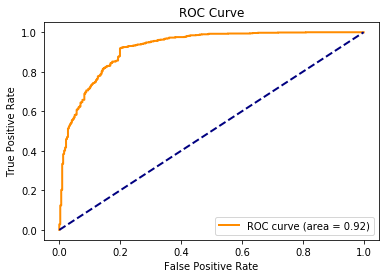

recall of bow+svm is 0.9788704251288639
f1score of bow+svm is 0.8995505850938045



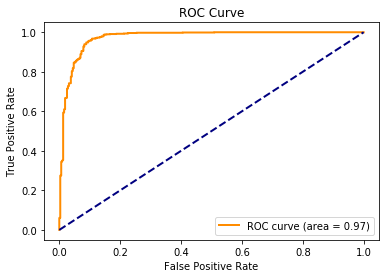

recall of tfidf+svm is 0.9877172403361529
f1score of tfidf+svm is 0.9582495499910217



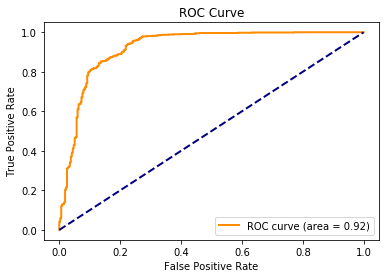

recall of cbow+svm is 0.9796051561099915
f1score of cbow+svm is 0.9222178108233414



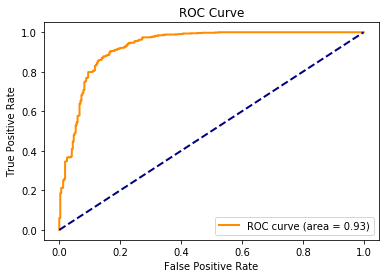

recall of skip_gram+svm is 0.9780507665216481
f1score of skip_gram+svm is 0.9222709879185353



In [8]:
from sklearn.model_selection import KFold
from sklearn import tree, metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn import svm

cv = KFold(n_splits=10, shuffle=True, random_state=1)

def draw_roc(y_score,y_test):
    fpr, tpr, thresholds = roc_curve(y_test, y_score);
    roc_auc = auc(fpr, tpr) 
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

#bow
bow_svm_recall = []
bow_svm_f1 = []

for train_ids, test_ids in cv.split(data['melody'].values):
    X_train,y_train = bow[train_ids], data['label'].values[train_ids]
    X_test,y_test = bow[test_ids], data['label'].values[test_ids]
    SVM = svm.SVC()
    SVM.fit(X_train,y_train) 
    y_pred = SVM.predict(X_test)
    bow_svm_recall.append(metrics.recall_score(y_test, y_pred))
    bow_svm_f1.append(metrics.f1_score(y_test, y_pred))
    y_score = SVM.fit(X_train, y_train).decision_function(X_test)
draw_roc(y_score,y_test)
    
print("recall of bow+svm is {}".format(np.mean(bow_svm_recall)))
print("f1score of bow+svm is {}\n".format(np.mean(bow_svm_f1)))

#tfidf
tfidf_svm_recall = []
tfidf_svm_f1 = []

for train_ids, test_ids in cv.split(data['melody'].values):
    X_train,y_train = tf_idf[train_ids], data['label'].values[train_ids]
    X_test,y_test = tf_idf[test_ids], data['label'].values[test_ids]
    SVM = svm.SVC()
    SVM.fit(X_train,y_train) 
    y_pred = SVM.predict(X_test)
    tfidf_svm_recall.append(metrics.recall_score(y_test, y_pred))
    tfidf_svm_f1.append(metrics.f1_score(y_test, y_pred))
    y_score = SVM.fit(X_train, y_train).decision_function(X_test)
draw_roc(y_score,y_test)

print("recall of tfidf+svm is {}".format(np.mean(tfidf_svm_recall)))
print("f1score of tfidf+svm is {}\n".format(np.mean(tfidf_svm_f1)))
    
#cbow
cbow_svm_recall = []
cbow_svm_f1 = []

for train_ids, test_ids in cv.split(data['melody'].values):
    X_train,y_train = cbow[train_ids], data['label'].values[train_ids]
    X_test,y_test = cbow[test_ids], data['label'].values[test_ids]
    SVM = svm.SVC()
    SVM.fit(X_train,y_train) 
    y_pred = SVM.predict(X_test)
    cbow_svm_recall.append(metrics.recall_score(y_test, y_pred))
    cbow_svm_f1.append(metrics.f1_score(y_test, y_pred))
    y_score = SVM.fit(X_train, y_train).decision_function(X_test)
draw_roc(y_score,y_test)

print("recall of cbow+svm is {}".format(np.mean(cbow_svm_recall)))
print("f1score of cbow+svm is {}\n".format(np.mean(cbow_svm_f1)))

#skip-gram
skip_gram_svm_recall = []
skip_gram_svm_f1 = []

for train_ids, test_ids in cv.split(data['melody'].values):
    X_train,y_train = skip_gram[train_ids], data['label'].values[train_ids]
    X_test,y_test = skip_gram[test_ids], data['label'].values[test_ids]
    SVM = svm.SVC()
    SVM.fit(X_train,y_train) 
    y_pred = SVM.predict(X_test)
    skip_gram_svm_recall.append(metrics.recall_score(y_test, y_pred))
    skip_gram_svm_f1.append(metrics.f1_score(y_test, y_pred))
    y_score = SVM.fit(X_train, y_train).decision_function(X_test)
draw_roc(y_score,y_test)

print("recall of skip_gram+svm is {}".format(np.mean(skip_gram_svm_recall)))
print("f1score of skip_gram+svm is {}\n".format(np.mean(skip_gram_svm_f1)))

## 3.2 深度学习模型

### （1）LSTM

CNN+bow
epoch:0 loss:78.89988531172276
epoch:5 loss:27.103237371891737
epoch:10 loss:18.878518225625157
epoch:15 loss:14.755463326349854
epoch:20 loss:11.427744202781469
epoch:25 loss:9.070572218857706
epoch:30 loss:7.962957396637648
epoch:35 loss:6.887617207947187
epoch:40 loss:6.257268113491591
epoch:45 loss:5.479511076351628
epoch:50 loss:5.339548928372096
epoch:55 loss:4.542874770615526
epoch:60 loss:4.226192454982083
epoch:65 loss:4.392471866682172
epoch:70 loss:3.8527779020296293
epoch:75 loss:3.7621687766804826
epoch:80 loss:3.4501864612902864
epoch:85 loss:3.4820420417090645
epoch:90 loss:4.465143741257634
epoch:95 loss:3.8900663927124697
epoch:100 loss:3.2448199668288
epoch:105 loss:3.034599122558575
epoch:110 loss:3.061578510219988
epoch:115 loss:2.8279389571689535
epoch:120 loss:3.1914272039139178
epoch:125 loss:2.661646035121521
epoch:130 loss:2.833136130841922
epoch:135 loss:3.3102999910115614
epoch:140 loss:3.128016138758653
epoch:145 loss:2.530584146014405
recall: 0.9840

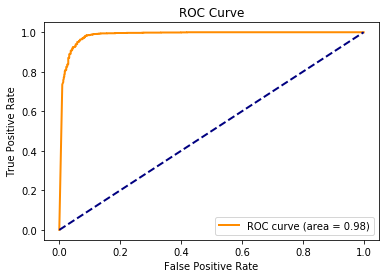

CNN+tfidf
epoch:0 loss:69.03355435281992
epoch:5 loss:13.166127399541438
epoch:10 loss:8.144869829760864
epoch:15 loss:6.225525339599699
epoch:20 loss:5.3433842576050665
epoch:25 loss:4.551456885441439
epoch:30 loss:3.8116812000225764
epoch:35 loss:4.063441759019042
epoch:40 loss:3.2524001475940167
epoch:45 loss:3.46602715275003
epoch:50 loss:3.097045031521702
epoch:55 loss:2.8769141178818245
epoch:60 loss:3.2267207652530487
epoch:65 loss:2.6422372539132084
epoch:70 loss:2.5591459378338186
epoch:75 loss:2.625413891354583
epoch:80 loss:3.7883162948855897
epoch:85 loss:2.389254264673582
epoch:90 loss:2.3281284921467886
epoch:95 loss:2.365430495119199
epoch:100 loss:2.2994408597464826
epoch:105 loss:2.239831582641216
epoch:110 loss:2.227937458164888
epoch:115 loss:2.1693855169110066
epoch:120 loss:2.1683488280541496
epoch:125 loss:3.2399333860664683
epoch:130 loss:2.196474317242746
epoch:135 loss:2.158541173073445
epoch:140 loss:2.108307091079098
epoch:145 loss:2.7134592978865157
recall: 

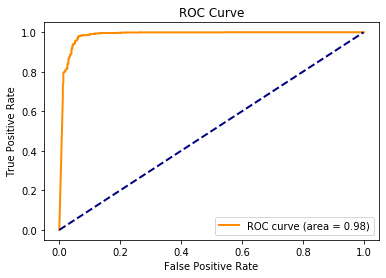

CNN+cbow
epoch:0 loss:79.37734006345272
epoch:5 loss:53.15398609638214
epoch:10 loss:49.42480931431055
epoch:15 loss:46.08110899478197
epoch:20 loss:44.81020864844322
epoch:25 loss:42.045122265815735
epoch:30 loss:40.47257578372955
epoch:35 loss:40.358804292976856
epoch:40 loss:37.5544414781034
epoch:45 loss:35.310941983014345
epoch:50 loss:33.0513686016202
epoch:55 loss:32.14991329982877
epoch:60 loss:30.20490452647209
epoch:65 loss:29.02721219882369
epoch:70 loss:27.46787102892995
epoch:75 loss:25.627225819975138
epoch:80 loss:24.696518199518323
epoch:85 loss:22.5390760935843
epoch:90 loss:22.492275036871433
epoch:95 loss:20.577406434342265
epoch:100 loss:19.53449209406972
epoch:105 loss:19.098009819164872
epoch:110 loss:16.645476351492107
epoch:115 loss:16.038798920810223
epoch:120 loss:15.348190541379154
epoch:125 loss:15.215753556229174
epoch:130 loss:12.872373760677874
epoch:135 loss:13.48349930997938
epoch:140 loss:14.089669675566256
epoch:145 loss:12.784229570999742
recall: 0.9

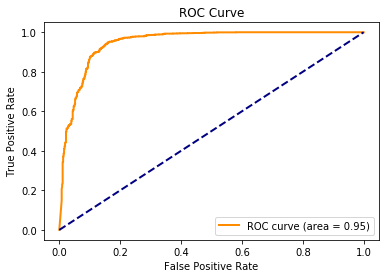

CNN+skipgram
epoch:0 loss:77.33188405632973
epoch:5 loss:50.48418553173542
epoch:10 loss:46.226658545434475
epoch:15 loss:43.21893476694822
epoch:20 loss:40.45201101899147
epoch:25 loss:38.39917512610555
epoch:30 loss:35.81441706046462
epoch:35 loss:33.27443094924092
epoch:40 loss:32.00687891244888
epoch:45 loss:28.997873153537512
epoch:50 loss:27.10081136971712
epoch:55 loss:25.60716969985515
epoch:60 loss:23.534554935991764
epoch:65 loss:22.442976132035255
epoch:70 loss:20.88744547404349
epoch:75 loss:19.047362953424454
epoch:80 loss:19.996296133846045
epoch:85 loss:18.10226060077548
epoch:90 loss:15.464843017980456
epoch:95 loss:14.712983916513622
epoch:100 loss:13.731964646372944
epoch:105 loss:14.248580250889063
epoch:110 loss:11.85280615836382
epoch:115 loss:11.580812172032893
epoch:120 loss:12.347422946244478
epoch:125 loss:10.469122880604118
epoch:130 loss:11.262106642127037
epoch:135 loss:9.78370493161492
epoch:140 loss:8.397094410378486
epoch:145 loss:8.879934895318002
recall

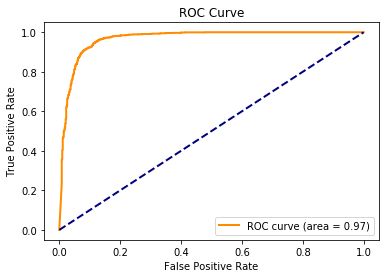

In [43]:
from sklearn.model_selection import train_test_split
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
 

def draw_roc(y_score,y_test):
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1]);
    roc_auc = auc(fpr, tpr) 
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


class RNN(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.rnn=torch.nn.LSTM(
            input_size = input_size,
            hidden_size=64,
            num_layers=2,
            batch_first=True
        )
        self.out=torch.nn.Linear(in_features=64,out_features=2)

    def forward(self,x):
        output,(h_n,c_n)=self.rnn(x)
        output_in_last_timestep=h_n[-1,:,:]
        out=self.out(output_in_last_timestep)
        return out


def RNN_eval(X_train,X_test,y_train,y_test):
    BATCH_SIZE = 50
    data_train = Data.TensorDataset(torch.tensor(X_train).float(),torch.tensor(y_train).float())
    data_test = Data.TensorDataset(torch.tensor(X_test).float(),torch.tensor(y_test).float())
    dataloader = Data.DataLoader(dataset=data_train,batch_size=BATCH_SIZE, shuffle=True) 

    m = X_train.shape[1]  
    net=RNN(int(m/2))
    net = net.cuda()

    optimizer=torch.optim.Adam(net.parameters(),lr=1e-3 )
    loss_F=torch.nn.CrossEntropyLoss()
    
    #train
    for epoch in range(150):
        train_loss = 0
        for step, input_data in enumerate(dataloader):
            x,y=input_data
            x = x.cuda()
            y = y.cuda()
            pred=net(x.view(-1,2,int(m/2)))
            loss=loss_F(pred,y.long()) 
            train_loss += loss.data.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch%5 == 0:
            print(f"epoch:{epoch} loss:{train_loss}")
    
    #test
    X_test = torch.tensor(X_test).float().cuda()
    output = net(X_test.view(-1,2,int(m/2)))
    y_score = torch.nn.functional.softmax(output,dim=1)
    y_pre = torch.argmax(y_score,dim=1)

    y_score = y_score.cpu()
    y_score = y_score.detach().numpy()
    y_pre = y_pre.cpu()
    y_pre = y_pre.detach().numpy()
    print("recall:",metrics.recall_score(y_test,y_pre,average='binary'))
    print("f1score:",metrics.f1_score(y_test,y_pre,average='binary'))
    draw_roc(y_score,y_test)

#main    
print('CNN+bow')
X_train,X_test,y_train,y_test = train_test_split(bow,data['label'].values,test_size = 0.2) 
RNN_eval(X_train,X_test,y_train,y_test)

print('CNN+tfidf')
X_train,X_test,y_train,y_test = train_test_split(tf_idf,data['label'].values,test_size = 0.2) 
RNN_eval(X_train,X_test,y_train,y_test)

print('CNN+cbow')
X_train,X_test,y_train,y_test = train_test_split(cbow,data['label'].values,test_size = 0.2) 
RNN_eval(X_train,X_test,y_train,y_test)

print('CNN+skipgram')
X_train,X_test,y_train,y_test = train_test_split(skip_gram,data['label'].values,test_size = 0.2) 
RNN_eval(X_train,X_test,y_train,y_test)

### （2）CNN

CNN+bow
epoch:0 loss:21.50912195444107
epoch:5 loss:19.077542424201965
epoch:10 loss:16.8601813018322
epoch:15 loss:15.46105894446373
epoch:20 loss:14.434374451637268
epoch:25 loss:13.741181254386902
epoch:30 loss:13.14387595653534
epoch:35 loss:12.641959324479103
epoch:40 loss:12.493011981248856
epoch:45 loss:12.171566426753998
epoch:50 loss:11.836940437555313
epoch:55 loss:11.805596470832825
epoch:60 loss:11.702424138784409
epoch:65 loss:11.535030901432037
epoch:70 loss:11.43370658159256
epoch:75 loss:11.198992028832436
epoch:80 loss:11.272680103778839
epoch:85 loss:11.051626563072205
epoch:90 loss:10.957453548908234
epoch:95 loss:10.937422841787338
epoch:100 loss:10.856390357017517
epoch:105 loss:10.766438335180283
epoch:110 loss:10.832772970199585
epoch:115 loss:10.659958437085152
epoch:120 loss:10.576466128230095
epoch:125 loss:10.752555191516876
epoch:130 loss:10.538823127746582
epoch:135 loss:10.548433065414429
epoch:140 loss:10.352800190448761
epoch:145 loss:10.493128314614296


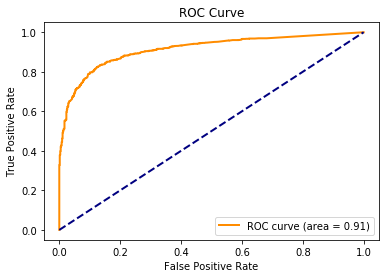

CNN+tfidf
epoch:0 loss:20.91597980260849
epoch:5 loss:12.150526732206345
epoch:10 loss:8.71054495871067
epoch:15 loss:7.357774183154106
epoch:20 loss:6.454768769443035
epoch:25 loss:6.096488460898399
epoch:30 loss:5.7078884690999985
epoch:35 loss:5.583914831280708
epoch:40 loss:5.394150577485561
epoch:45 loss:5.2299585565924644
epoch:50 loss:5.026908211410046
epoch:55 loss:4.944519676268101
epoch:60 loss:4.889988526701927
epoch:65 loss:4.8602046594023705
epoch:70 loss:4.7483066990971565
epoch:75 loss:4.598586484789848
epoch:80 loss:4.586835831403732
epoch:85 loss:4.511026449501514
epoch:90 loss:4.5465928837656975
epoch:95 loss:4.610209666192532
epoch:100 loss:4.510057434439659
epoch:105 loss:4.562641762197018
epoch:110 loss:4.425163879990578
epoch:115 loss:4.30877735093236
epoch:120 loss:4.378793872892857
epoch:125 loss:4.276168506592512
epoch:130 loss:4.251258507370949
epoch:135 loss:4.344143770635128
epoch:140 loss:4.279502026736736
epoch:145 loss:4.174167729914188
reacll: 0.96112852

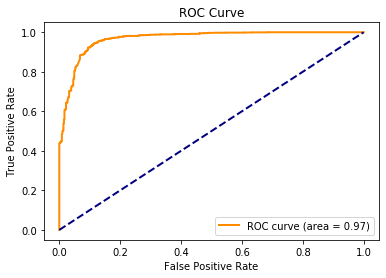

CNN+cbow
epoch:0 loss:21.030954718589783
epoch:5 loss:16.495139330625534
epoch:10 loss:15.447296410799026
epoch:15 loss:15.007166683673859
epoch:20 loss:14.705210000276566
epoch:25 loss:14.557131379842758
epoch:30 loss:14.238959938287735
epoch:35 loss:14.495800018310547
epoch:40 loss:14.280579060316086
epoch:45 loss:14.254608929157257
epoch:50 loss:14.17166918516159
epoch:55 loss:13.942389771342278
epoch:60 loss:14.088508993387222
epoch:65 loss:14.079223871231079
epoch:70 loss:14.000360906124115
epoch:75 loss:14.061854094266891
epoch:80 loss:13.89376613497734
epoch:85 loss:14.026725858449936
epoch:90 loss:13.839163064956665
epoch:95 loss:13.86044830083847
epoch:100 loss:13.752761900424957
epoch:105 loss:14.1096151471138
epoch:110 loss:13.744947969913483
epoch:115 loss:13.793423801660538
epoch:120 loss:13.916061490774155
epoch:125 loss:13.67785793542862
epoch:130 loss:13.714626967906952
epoch:135 loss:13.733226388692856
epoch:140 loss:13.608752012252808
epoch:145 loss:13.780773997306824

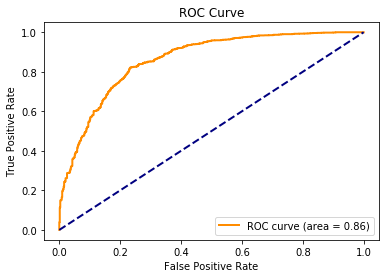

CNN+skipgram
epoch:0 loss:26.780673146247864
epoch:5 loss:19.879866898059845
epoch:10 loss:19.046998530626297
epoch:15 loss:18.48053875565529
epoch:20 loss:18.181571573019028
epoch:25 loss:18.085338294506073
epoch:30 loss:17.998062551021576
epoch:35 loss:17.826069355010986
epoch:40 loss:17.606851130723953
epoch:45 loss:17.52699765563011
epoch:50 loss:17.54177436232567
epoch:55 loss:17.614004850387573
epoch:60 loss:17.527223855257034
epoch:65 loss:17.42675945162773
epoch:70 loss:17.341127812862396
epoch:75 loss:17.474514067173004
epoch:80 loss:17.60855233669281
epoch:85 loss:17.445520162582397
epoch:90 loss:17.40723407268524
epoch:95 loss:17.40863886475563
epoch:100 loss:17.43949407339096
epoch:105 loss:17.5140942633152
epoch:110 loss:17.38735204935074
epoch:115 loss:17.49940624833107
epoch:120 loss:17.237046092748642
epoch:125 loss:17.403384685516357
epoch:130 loss:17.35479947924614
epoch:135 loss:17.31638291478157
epoch:140 loss:17.452461808919907
epoch:145 loss:17.409543126821518
rea

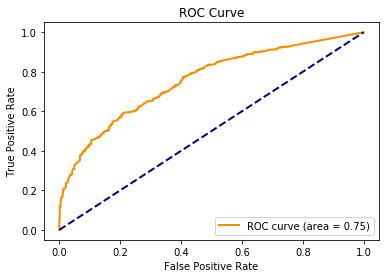

In [52]:
from sklearn.model_selection import train_test_split
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import  metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def draw_roc(y_score,y_test):
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1]);
    roc_auc = auc(fpr, tpr) 
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

class CNN(torch.nn.Module):

    def __init__(self,X_train):
        super(CNN, self).__init__()
        self.conv3 = nn.Conv2d(1, 1, kernel_size=(3, X_train.shape[2]))
        self.conv4 = nn.Conv2d(1, 1, kernel_size=(4, X_train.shape[2]))
        self.conv5 = nn.Conv2d(1, 1, kernel_size=(5, X_train.shape[2]))
        self.Max3_pool = nn.MaxPool2d((X_train.shape[1]-3+1, 1))
        self.Max4_pool = nn.MaxPool2d((X_train.shape[1]-4+1, 1))
        self.Max5_pool = nn.MaxPool2d((X_train.shape[1]-5+1, 1))
        self.linear1 = nn.Linear(3, 2)

    def forward(self, x):
        batch = x.shape[0]
        # 卷积
        x = x.unsqueeze(1)
        x1 = F.relu(self.conv3(x))
        x2 = F.relu(self.conv4(x))
        x3 = F.relu(self.conv4(x))

        # 池化
        x1 = self.Max3_pool(x1)
        x2 = self.Max4_pool(x2)
        x3 = self.Max4_pool(x3)
        
        # 将抓住的这些特征连在一起
        x = torch.cat((x1, x2, x3), -1)
        x = x.view(batch, 1, -1)

        # 把特征映射至标签
        x = self.linear1(x)
        x = x.view(-1, 2)

        return x

def CNN_eval(X_train,X_test,y_train,y_test):
    batch_size = 256
    
    data_train = Data.TensorDataset(torch.tensor(X_train).float(),torch.tensor(y_train).float())
    data_test = Data.TensorDataset(torch.tensor(X_test).float(),torch.tensor(y_test).float())
    dataloader = Data.DataLoader(dataset=data_train,batch_size=batch_size, shuffle=True) 

    net=CNN(X_train)
    net = net.cuda()


    optimizer=torch.optim.Adam(net.parameters(),lr=1e-3)
    loss_F=torch.nn.CrossEntropyLoss()
    
    #train
    for epoch in range(150): 
        train_loss = 0
        for step, input_data in enumerate(dataloader):
            x,y=input_data
            x = x.cuda()
            y = y.cuda()
            pred=net(x)
            loss=loss_F(pred,y.long()) 
            train_loss += loss.data.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch%5 == 0:
            print(f"epoch:{epoch} loss:{train_loss}")
            
    #test
    X_test = torch.tensor(X_test).float().cuda()
    output = net(X_test)
    y_score = torch.nn.functional.softmax(output,dim=1)
    y_pre = torch.argmax(y_score,dim=1)

    y_score = y_score.cpu()
    y_score = y_score.detach().numpy()
    y_pre = y_pre.cpu()
    y_pre = y_pre.detach().numpy()
    print("reacll:",metrics.recall_score(y_test,y_pre,average='binary'))
    print("f1score:",metrics.f1_score(y_test,y_pre,average='binary'))
    draw_roc(y_score,y_test)

    
#main
print('CNN+bow')
X_train,X_test,y_train,y_test = train_test_split(CNN_bow,data['label'].values,test_size = 0.2) 
CNN_eval(X_train,X_test,y_train,y_test)

print('CNN+tfidf')
X_train,X_test,y_train,y_test = train_test_split(CNN_tf_idf,data['label'].values,test_size = 0.2) 
CNN_eval(X_train,X_test,y_train,y_test)

print('CNN+cbow')
X_train,X_test,y_train,y_test = train_test_split(CNN_CBOW,data['label'].values,test_size = 0.2) 
CNN_eval(X_train,X_test,y_train,y_test)

print('CNN+skipgram')
X_train,X_test,y_train,y_test = train_test_split(CNN_skipgram,data['label'].values,test_size = 0.2) 
CNN_eval(X_train,X_test,y_train,y_test)